<a href="https://colab.research.google.com/github/kutay-oksuzz/-Deeplearning_food_vision_classification_EfficientNet_model/blob/main/Food_vision_classification_EfficientNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [68]:
# Import torchinfo
try:
  from torchinfo import summary
  print("Library added...")
except:
  print("torchinfo not found!...")
  !pip install torchinfo
  from torchinfo import summary
  print("Library added...")

Library added...


In [69]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
# Get data
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exists.")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

  os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi already exists.


In [71]:
# Setup directory path 
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [72]:
import torch
from torch import nn
import os

from torchvision import transforms, datasets

from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int=NUM_WORKERS):
  
  
  
  train_data = datasets.ImageFolder(root=train_dir,
                                    transform=transform)
  test_data = datasets.ImageFolder(root=test_dir,
                                   transform=transform)
  
  class_names = train_data.classes

  train_dataloader = DataLoader(dataset=train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=NUM_WORKERS,
                                pin_memory=True)
  test_dataloader = DataLoader(dataset=test_data,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=NUM_WORKERS,
                               pin_memory=True)
  
  return train_dataloader, test_dataloader, class_names  

In [73]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [74]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [75]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=auto_transforms,
                                                                    batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fdabf6f8730>,
 ['pizza', 'steak', 'sushi'])

In [76]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [77]:
summary(model=model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"],
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

In [78]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [79]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [80]:
summary(model=model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"],
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [81]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [82]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [83]:
# Create an accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [84]:
from typing import Tuple, List, Dict

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy: accuracy_fn,
               device: torch.device = device) -> Tuple[float, float]:
  
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    
    # 2. Calculate loss and accuracy functions
    loss = loss_fn(y_pred,
                   y)
    train_loss += loss.item()
    train_acc += accuracy(y_true=y,
                          y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc   

In [85]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy: accuracy_fn,
              device: torch.device = device) -> Tuple[float, float]:

  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss and accuracy functions
      test_loss += loss_fn(test_pred,
                           y).item()
      test_acc += accuracy(y_true=y,
                           y_pred=test_pred.argmax(dim=1))

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc                                     

In [86]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy: accuracy_fn,
          epochs: int,
          device: torch.device = device) -> Dict[str, List]:

  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy=accuracy,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy=accuracy,
                                    device=device)
    
    # Print out what's happening
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")
        


    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
  return results  


In [87]:
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      accuracy=accuracy_fn,
                      epochs=8,
                      device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 38.2812 | test_loss: 0.8856 | test_acc: 68.2765
Epoch: 2 | train_loss: 0.9211 | train_acc: 65.6250 | test_loss: 0.7920 | test_acc: 82.5758
Epoch: 3 | train_loss: 0.7553 | train_acc: 86.7188 | test_loss: 0.6486 | test_acc: 91.6667
Epoch: 4 | train_loss: 0.7376 | train_acc: 70.7031 | test_loss: 0.5954 | test_acc: 89.5833
Epoch: 5 | train_loss: 0.6272 | train_acc: 76.5625 | test_loss: 0.6106 | test_acc: 89.6780
Epoch: 6 | train_loss: 0.5741 | train_acc: 78.5156 | test_loss: 0.5588 | test_acc: 87.6894
Epoch: 7 | train_loss: 0.5667 | train_acc: 78.9062 | test_loss: 0.5848 | test_acc: 87.6894
Epoch: 8 | train_loss: 0.4989 | train_acc: 78.1250 | test_loss: 0.4988 | test_acc: 90.7197


failed


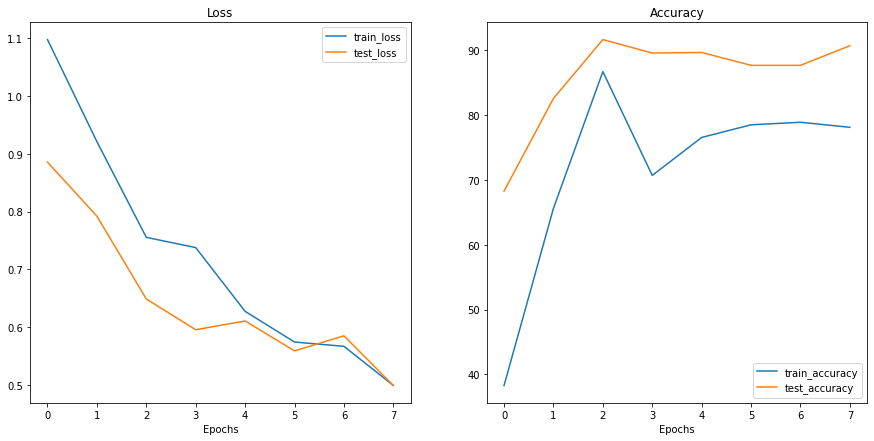

In [88]:
try:
  from helper_functions import plot_loss_curves
  print("failed")
except:
  print(f"[INFO] Couldn't find helper_function.py; downloading... ")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)

  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_results) 


In [107]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
     
      target_image_pred = model(transformed_image.to(device))
    
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

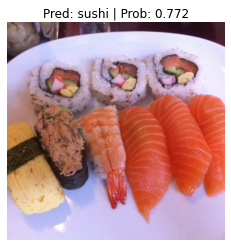

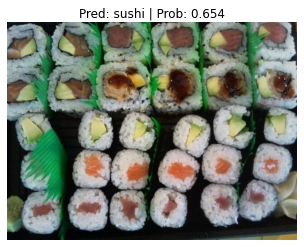

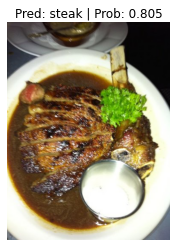

In [108]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))  
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot) 

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(),
                        image_size=(224, 224))